<a href="https://colab.research.google.com/github/NochnoyRitzar/Ted-Talks-Analysis/blob/master/prototyping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from ast import literal_eval
!pip install category-encoders
from category_encoders import BinaryEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# for plotting
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
sns.set(style="darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
np.random.seed(42)

In [3]:
# loading clean data
df = pd.read_csv('https://raw.githubusercontent.com/NochnoyRitzar/Ted-Talks-Analysis/master/data/intermediate/clean_data.csv')

In [4]:
df.head()

,duration,event,likes,published_date,subtitle_languages,summary,title,topics,views
0,992,TED,17052,2006-08-25,"['English', 'Vietnamese', 'Italian', 'Arabic',...","The founding mother of the blog revolution, Mo...",Meet the founder of the blog revolution,"['culture', 'design', 'business', 'entertainme...",589115
1,957,TED,110861,2006-06-27,"['Greek', 'Gujarati', 'English', 'Italian', 'S...",With the same humor and humanity he exuded in ...,Averting the climate crisis,"['climate change', 'culture', 'environment', '...",3671801
2,1266,TED,60015,2006-06-27,"['Greek', 'English', 'Vietnamese', 'Italian', ...",New York Times columnist David Pogue takes aim...,Simplicity sells,"['technology', 'computers', 'entertainment', '...",2008487
3,1126,TEDGlobal,80072,2006-09-12,"['Greek', 'English', 'Vietnamese', 'Italian', ...",Legendary scientist David Deutsch puts theoret...,Chemical scum that dream of distant quasars,"['climate change', 'culture', 'environment', '...",2694257
4,1524,TED,14061,2006-07-25,"['English', 'Vietnamese', 'Italian', 'Arabic',...",Jehane Noujaim unveils her 2006 TED Prize wish...,My wish: A global day of film,"['culture', 'global issues', 'entertainment', ...",489757


Let's check column contents after cleaning

In [5]:
# convert cell values from str to list
df['subtitle_languages'] = df['subtitle_languages'].apply(literal_eval)
df['topics'] = df['topics'].apply(literal_eval)

In [6]:
topics_series = df['topics'].explode()
print(f'There are {topics_series.nunique()} unique topics', end='\n\n')
plot = px.scatter(topics_series.value_counts())
plot.update_layout(xaxis_title="Topic", yaxis_title="Count")
plot.show()

There are 352 unique topics



Topics column is very important, we cant drop it. In order to use it for regression analysis we have to encode it. <br>
Due to the high amount of unique topics and the number of topics assigned to a talk, we will choose 3 first topics out of the list and encode them using Binary encoding

In [7]:
num_topics_series = df['topics'].apply(lambda row: len(row))
px.histogram(
    x=num_topics_series, 
    y=df['views'], 
    labels={'x': 'Number of topics', 'y': 'Views'}, 
    title='Sum of views across number of topics'
)

In [8]:
plot = px.scatter(df['event'].value_counts(), color=df['event'].value_counts().index)
plot.update_layout(xaxis_title="Event", yaxis_title="Count")
plot.show()

In [9]:
series = df[['published_date', 'event']].value_counts()
fig = px.histogram(
    x=series.index.get_level_values(0), 
    y=series, 
    labels={'x': 'Published Date', 'y':'talks published that month by event'}, 
    title='Monthly count of published talks grouped by event',
    color=series.index.get_level_values(1),
    nbins=200
)
fig.update_layout(bargap=0.1)

We can see that some events are still active, but some (TEDIndia, EG) had their last talks in 2009-2010

In [10]:
def encode_event_column(df):
    encoder = BinaryEncoder(cols=['event'], return_df=True)
    df = encoder.fit_transform(df)
    return df

In [11]:
def encode_topics_column(df):
    topics_series = df['topics'].explode().unique()
    # create a dataframe with 3 same columns
    df_topics = pd.DataFrame(topics_series, columns=['topic_1'])
    df_topics['topic_2'] = df_topics['topic_1']
    df_topics['topic_3'] = df_topics['topic_1']

    for topic_num in range(0, 3):
        df[f'topic_{topic_num + 1}'] = df['topics'].apply(lambda array: array[topic_num])
        
    encoder = BinaryEncoder(cols=['topic_1', 'topic_2', 'topic_3'], return_df=True)
    # fit on df_topics to include all topics into encoder mapping
    encoder.fit(df_topics)
    df_topics = encoder.transform(df.loc[:, 'topic_1':'topic_3'])

    df = df.drop(columns=['topics', 'topic_1', 'topic_2', 'topic_3'])
    df = pd.concat([df, df_topics], axis=1)

    return df

In [12]:
def create_new_features(df):
    df['title_length'] = df['title'].apply(lambda title: len(title))
    df['summary_length'] = df['summary'].apply(lambda summary: len(summary))
    df['num_subtitles'] = df['subtitle_languages'].apply(lambda array: len(array))
    # days passed since publication to the time when dataset was created
    df['days_passed'] = (datetime.strptime('2022-09-01', '%Y-%m-%d') - pd.to_datetime(df['published_date'])).dt.days
    df['log_duration'] = df['duration'].apply(np.log)
    df['log_likes'] = df['likes'].apply(np.log)

    df = df.drop(columns=['title', 'summary', 'subtitle_languages', 'published_date', 'duration', 'likes'])
    return df

In [13]:
df = encode_topics_column(df)
df = encode_event_column(df)
df = create_new_features(df)

In [14]:
df.head()

,event_0,event_1,event_2,event_3,event_4,views,topic_1_0,topic_1_1,topic_1_2,topic_1_3,...,topic_3_5,topic_3_6,topic_3_7,topic_3_8,title_length,summary_length,num_subtitles,days_passed,log_duration,log_likes
0,0,0,0,0,1,589115,0,0,0,0,...,0,0,1,1,39,250,21,5851,6.899723,9.744023
1,0,0,0,0,1,3671801,0,0,0,0,...,1,0,1,0,27,233,43,5910,6.863803,11.616032
2,0,0,0,0,1,2008487,0,0,0,0,...,0,1,0,0,16,202,27,5910,7.143618,11.002350
3,0,0,0,1,0,2694257,0,0,0,0,...,1,0,1,0,43,230,29,5833,7.026427,11.290682
4,0,0,0,0,1,489757,0,0,0,0,...,0,1,0,0,29,121,20,5882,7.329094,9.551160


In [15]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution of Log duration", "Distribution of Log likes"))

# add graphs
fig.add_trace(
    go.Histogram(x=df['log_duration']),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df['log_likes']),
    row=1, col=2
)

# Update xaxis properties
fig.update_xaxes(title_text="Log duration", row=1, col=1)
fig.update_xaxes(title_text="Log likes", row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)

fig.update_layout(height=600, width=1000)
fig.show()

In [16]:
px.scatter(df, x='days_passed', y='views', title='Views vs Days passed since publication', color='days_passed')

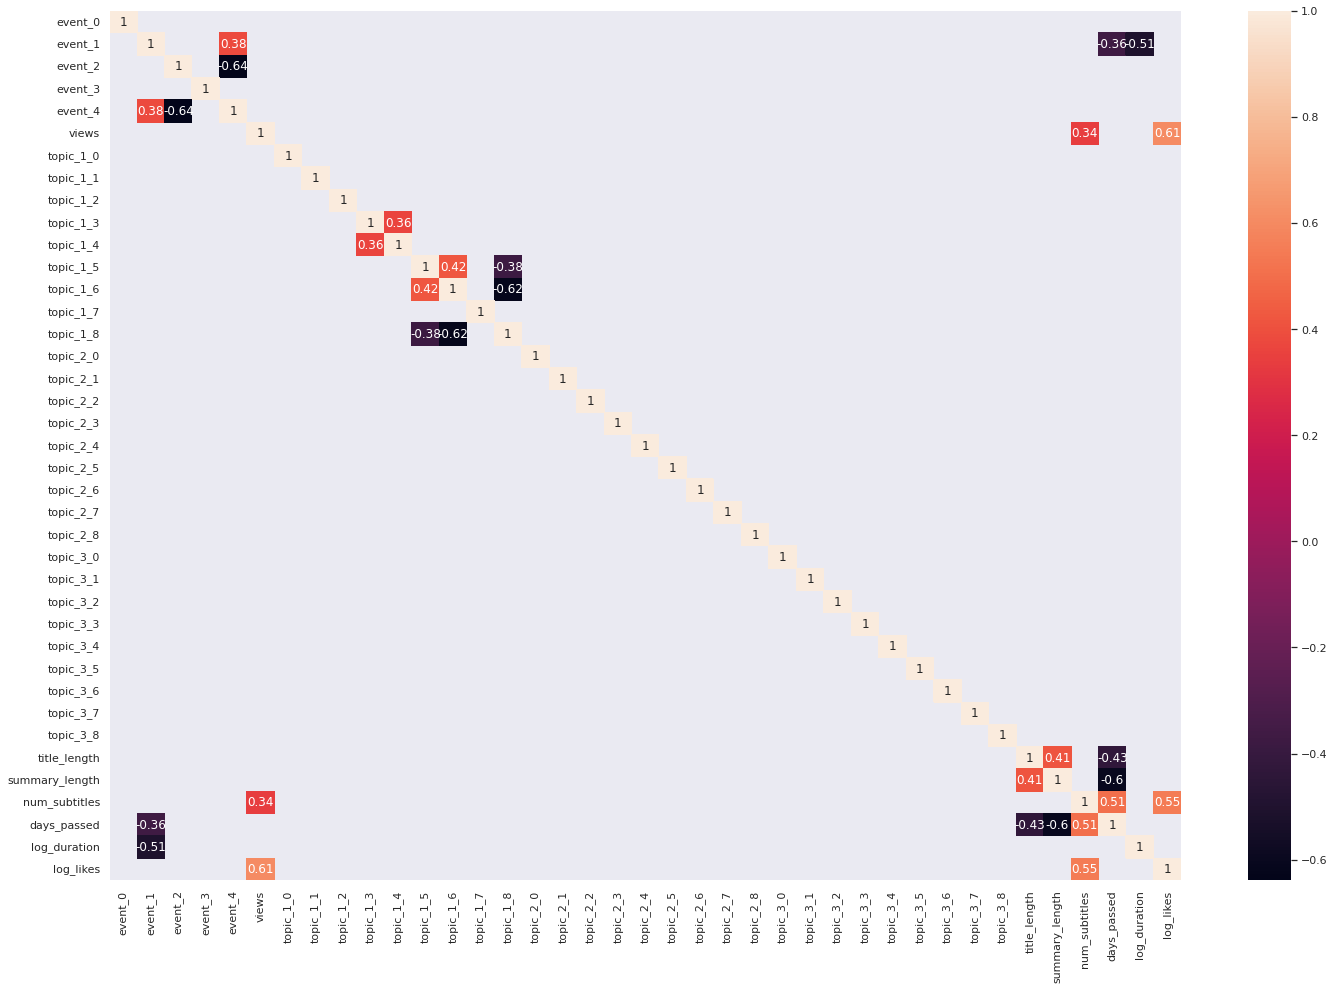

In [17]:
corr_matrix = df.corr()

plt.figure(figsize=(24, 16))
mask = np.abs(corr_matrix) < 0.3
sns.heatmap(corr_matrix, annot=True, mask=mask)

In [18]:
unscaled_df = df.loc[:, 'title_length':'log_likes']
unscaled_df_cols = unscaled_df.columns

In [19]:
fig = make_subplots(rows=2, cols=3)

# add graphs
for index, col in enumerate(unscaled_df_cols[0:3]):
    fig.add_trace(
        go.Box(x=df[col], orientation='h'),

        row=1, col=index + 1
    )

    fig.update_xaxes(title_text=col, row=1, col=index + 1)

for index, col in enumerate(unscaled_df_cols[3:6]):
    fig.add_trace(
        go.Box(x=df[col], orientation='h'),
        row=2, col=index + 1
    )

    fig.update_xaxes(title_text=col, row=2, col=index + 1)

fig.update_layout(height=800, width=1400)
fig.show()

In [20]:
fig = make_subplots(rows=2, cols=3)

# add graphs
for index, col in enumerate(unscaled_df_cols[0:3]):
    fig.add_trace(
        go.Histogram(x=df[col]),
        row=1, col=index + 1
    )

    fig.update_xaxes(title_text=col, row=1, col=index + 1)

for index, col in enumerate(unscaled_df_cols[3:6]):
    fig.add_trace(
        go.Histogram(x=df[col]),
        row=2, col=index + 1
    )

    fig.update_xaxes(title_text=col, row=2, col=index + 1)

fig.update_layout(height=800, width=1400)
fig.show()

In [21]:
def split_data(df):
    """
    Split data into train and testing datasets. \n
    :param df: original Dataframe
    :return: training and testing dataset
    """
    X = df.drop(columns=['views'])
    y = df['views']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    return X_train, y_train, X_test, y_test

In [22]:
X_train, y_train, X_test, y_test = split_data(df)

In [23]:
standard_scale_cols = ['title_length', 'summary_length', 'num_subtitles']
minmax_scale_cols = ['days_passed', 'log_duration']
robust_scale_cols = ['log_likes']

In [24]:
def scale_numerical_data(X_train, X_test):
    minmax_scaler = MinMaxScaler()
    # fit_transform on train data
    X_train[unscaled_df_cols] = minmax_scaler.fit_transform(X_train[unscaled_df_cols])
    # ONLY transform on test data!!!
    X_test[unscaled_df_cols] = minmax_scaler.transform(X_test[unscaled_df_cols])

    return X_train, X_test

In [25]:
X_train, X_test = scale_numerical_data(X_train, X_test)

In [26]:
fig = make_subplots(rows=2, cols=3)

# add graphs
for index, col in enumerate(unscaled_df_cols[0:3]):
    fig.add_trace(
        go.Histogram(x=X_train[col]),
        row=1, col=index + 1
    )

    fig.update_xaxes(title_text=col, row=1, col=index + 1)

for index, col in enumerate(unscaled_df_cols[3:6]):
    fig.add_trace(
        go.Histogram(x=X_train[col]),
        row=2, col=index + 1
    )

    fig.update_xaxes(title_text=col, row=2, col=index + 1)

fig.update_layout(height=800, width=1400)
fig.show()